In [1]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel


In [ ]:
%pip install datasets==2.21.0

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

In [4]:
def filter_dataset(dataset, minlen: int, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]["en"]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen and len(dataset[i]["en"].split(" "))>=minlen
    ]

In [5]:
maxlen = 30
minlen = 5
train_filtered = filter_dataset(train_dataset, minlen, maxlen)
test_filtered = filter_dataset(test_dataset, minlen, maxlen)
print(len(train_filtered), len(test_filtered))

28945 997


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
tiny_bert_model = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D").to(device)
embedding_matrix = tiny_bert_model.embeddings.word_embeddings.weight
embedding_matrix.shape

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

torch.Size([30522, 312])

In [ ]:
print("Размер словаря: ", len(tokenizer))

Размер словаря:  30522


In [ ]:
batch = [train_filtered[i] for i in range(4)]
print(batch)
encoded_batch = tokenizer.batch_encode_plus(
    batch, padding="longest", return_tensors="pt", return_attention_mask=False
)['input_ids']
print(encoded_batch)

['Two young, White males are outside near many bushes.', 'Several men in hard hats are operating a giant pulley system.', 'A little girl climbing into a wooden playhouse.', 'A man in a blue shirt is standing on a ladder cleaning a window.']
tensor([[  101,  2048,  2402,  1010,  2317,  3767,  2024,  2648,  2379,  2116,
         14568,  1012,   102,     0,     0,     0,     0],
        [  101,  2195,  2273,  1999,  2524, 16717,  2024,  4082,  1037,  5016,
          4139,  3240,  2291,  1012,   102,     0,     0],
        [  101,  1037,  2210,  2611,  8218,  2046,  1037,  4799, 17408,  1012,
           102,     0,     0,     0,     0,     0,     0],
        [  101,  1037,  2158,  1999,  1037,  2630,  3797,  2003,  3061,  2006,
          1037, 10535,  9344,  1037,  3332,  1012,   102]])


In [8]:
def collate_fn(
    tokenizer: AutoTokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    encoded_batch = tokenizer.batch_encode_plus(
        batch, padding="longest", return_tensors="pt", return_attention_mask=False)['input_ids']
    return encoded_batch.to(device)

In [9]:
train_loader = DataLoader(train_filtered, batch_size=32, shuffle=True, collate_fn=lambda batch:collate_fn(tokenizer,batch))
test_loader = DataLoader(test_filtered, batch_size=32, shuffle=True, collate_fn=lambda batch:collate_fn(tokenizer,batch))
tokens = next(iter(train_loader))

In [ ]:
tokens.shape

(torch.Size([32, 30]), torch.Size([32, 768]))

In [10]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim+hidden_dim, hidden_dim)
        torch.nn.init.kaiming_normal_(self.linear.weight, nonlinearity='tanh')

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

In [11]:
class RNN_encoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 1024, cell: nn.Module = RNNCell, pretrained_emb_matrix: Tensor = embedding_matrix) -> None:
        super().__init__()
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.embed = nn.Embedding.from_pretrained(pretrained_emb_matrix, freeze=True)
        self.rnn = cell(pretrained_emb_matrix.size(1), hidden_dim)


    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x input_dim
        B, T = x.shape

        x = self.embed(x) # B x T x input_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        return h # B x hidden , берём последний выход rnn

In [ ]:
tokens.shape

torch.Size([32, 30])

In [ ]:
encoder = RNN_encoder(
    vocab_size=len(tokenizer)
).to(device)
sent_emb = encoder.forward(tokens)
print(sent_emb.shape)

torch.Size([32, 1024])


In [12]:
class RNN_decoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 1024, cell: nn.Module = RNNCell) -> None:
        super().__init__()
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = cell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, T: int) -> Tensor:
        # x: B x S (S - sentence_emb_dim)
        B, S = x.shape
        x = x.unsqueeze(1).expand((B, T, S))

        h = self.init_h.expand((B, -1)) # B x hidden_dim

        res = []
        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x vocab_size, для каждой позиции на вызоде линейного слоя получаем логиты на размер словаря(для cross entropy)
            res.append(y)

        return torch.cat(res, dim=1) # B x T x vocab_size

In [ ]:
decoder = RNN_decoder(vocab_size=len(tokenizer)).to(device)
decoder.forward(sent_emb, tokens.shape[1]).shape

torch.Size([32, 30, 30522])

In [25]:
class SentenceAutoEncoder(nn.Module):
  def __init__(self, vocab_size, hidden_dim:int=1024, pretrained_emb_matrix: Tensor = embedding_matrix)-> None:
    super().__init__()
    self.encoder = RNN_encoder(vocab_size,hidden_dim = hidden_dim, pretrained_emb_matrix=pretrained_emb_matrix)
    self.l = nn.Linear(hidden_dim, hidden_dim)
    self.dropout = nn.Dropout(0.3)
    self.decoder = RNN_decoder(vocab_size, hidden_dim=hidden_dim)

  def forward(self, x: Tensor)-> Tensor:
    B, T = x.shape
    sent_emb = self.encoder(x)

    logits = self.decoder(sent_emb, T)

    return logits



In [15]:
autoencoder = SentenceAutoEncoder(vocab_size=len(tokenizer)).to(device)
logits = autoencoder.forward(tokens)
logits.shape, tokens.shape

(torch.Size([32, 26, 30522]), torch.Size([32, 26]))

In [16]:
def train_epoch(dataloader: DataLoader,model: nn.Module,optimizer: torch.optim.Optimizer):
    model.train()
    loss_total = 0
    n_total = 0
    n_correct = 0

    for tokens in dataloader:
        tokens = tokens.to(device)
        logits = model(tokens)

        #F.cross_entropy принимает два столбца, поэтому преобразуем форму(Bx T сливаем в одну размерность)
        loss = F.cross_entropy(
            logits.reshape(-1, len(tokenizer)),
            tokens.reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        b_size = tokens.size(0)*tokens.size(1)
        n_total += b_size
        loss_total +=  b_size*loss.item()
        n_correct += (tokens == logits.argmax(dim=-1)).sum().item()

    loss=loss_total / n_total
    acc = n_correct / n_total

    train_loss.append(loss)
    train_acc.append(acc)

In [17]:
@torch.no_grad()
def test_epoch(dataloader: DataLoader,model: nn.Module):
    model.eval()
    loss_total = 0
    n_total = 0
    n_correct = 0

    for tokens in dataloader:
        tokens = tokens.to(device)
        logits = model(tokens)

        loss = F.cross_entropy(
            logits.reshape(-1, len(tokenizer)),
            tokens.reshape(-1),
        )
        b_size = tokens.size(0)*tokens.size(1)
        n_total += b_size
        loss_total +=  b_size*loss.item()
        n_correct += (tokens == logits.argmax(dim=-1)).sum().item()

    loss=loss_total / n_total
    acc = n_correct / n_total

    val_loss.append(loss)
    val_acc.append(acc)

In [26]:
torch.manual_seed(42)
model1 = SentenceAutoEncoder(vocab_size=len(tokenizer)).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001, weight_decay=1e-5)
EPOCHS = 15
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model1,optimizer)
    test_epoch(test_loader,model1)
    print(f"Train_loss={train_loss[-1]}, Val_loss={val_loss[-1]}")
    print(f"Train_accuracy={train_acc[-1]}, Val_accuracy={val_acc[-1]}")

EPOCH 0
Train_loss=3.2914422167611526, Val_loss=2.723959313546553
Train_accuracy=0.5097844695712175, Val_accuracy=0.5391008828635809
EPOCH 1
Train_loss=2.780677024789483, Val_loss=2.6572891567192105
Train_accuracy=0.5583903318658548, Val_accuracy=0.5833646404688556
EPOCH 2
Train_loss=2.6650655933667164, Val_loss=2.749398625895804
Train_accuracy=0.5814592225515502, Val_accuracy=0.5641408440447148
EPOCH 3
Train_loss=2.627821361251202, Val_loss=2.6138991496917265
Train_accuracy=0.5864843037780434, Val_accuracy=0.5832076235328747
EPOCH 4
Train_loss=2.618971444056264, Val_loss=2.5646239615838344
Train_accuracy=0.5869547588840787, Val_accuracy=0.6022526750516238
EPOCH 5
Train_loss=2.5935732343667968, Val_loss=2.54009936509486
Train_accuracy=0.5904739677589274, Val_accuracy=0.6055495306832205
EPOCH 6
Train_loss=2.582607637673445, Val_loss=2.5300782441863663
Train_accuracy=0.5911137267592989, Val_accuracy=0.6057244286665188
EPOCH 7
Train_loss=2.607668509216007, Val_loss=2.5892280371343297
Trai

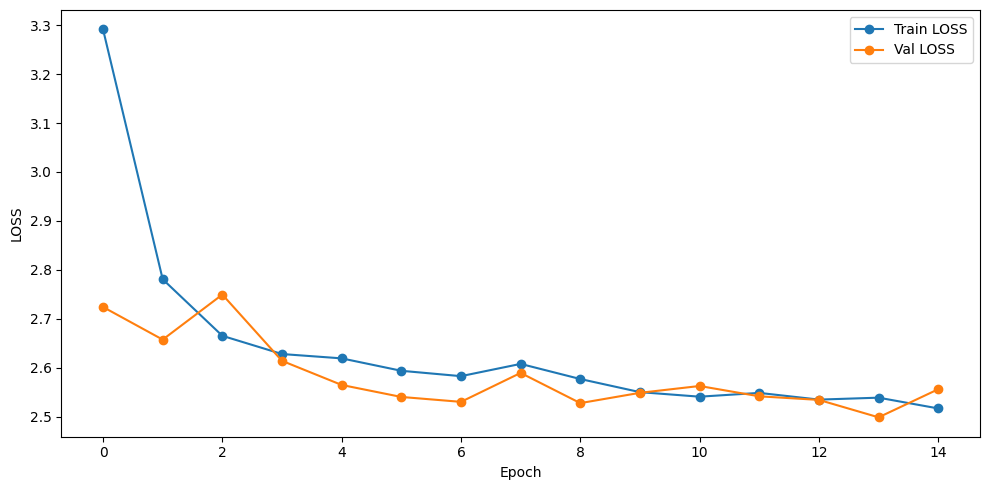

In [27]:
import matplotlib.pyplot as plt

def grafics(train_acc, val_acc, conf):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label=f"Train {conf}", marker='o')
    plt.plot(val_acc, label=f"Val {conf}", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel(conf)
    plt.legend()
    plt.tight_layout()
    plt.show()

grafics(train_loss,val_loss, "LOSS")

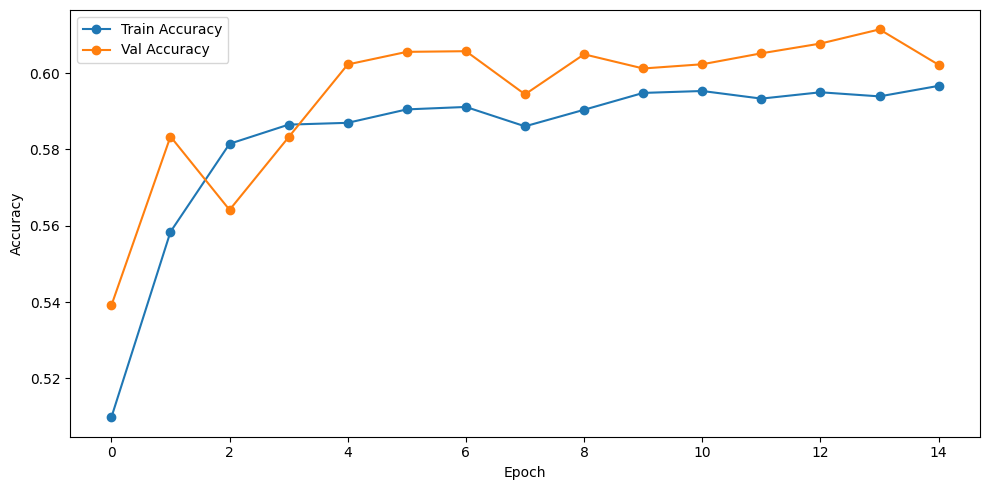

In [28]:
grafics(train_acc,val_acc, "Accuracy")

In [29]:
batch = next(iter(test_loader)).to(device)
text_in = tokenizer.batch_decode(batch, skip_special_tokens=True)
batch.shape

torch.Size([32, 30])

In [30]:
text_in

['in a outdoor market two men shovel snow and slush out of the path.',
 'a woman plays with finger puppets as a small child in a costume walks by.',
 'people sit on a bench in a city square with random objects including a lamp and a dressmakers form standing nearby.',
 'a young boy is hanging onto a clothing rack.',
 'a baby playing with her toys looking at a black and white cat.',
 'a boy standing in the foreground looking out over other people in a court.',
 'two women are holding hands over a table and smiling at the camera.',
 "three children's legs are shown as they stand near a mess of silly string.",
 'a woman looks on as a man with folded arms is talking.',
 'a man in a black and white jersey is holding yellow ski poles and preparing to take off.',
 'shirtless guy staring off in the distance while three woman are walking past a crowd sitting outside a cafe.',
 'a girl wearing a life vest floats in water.',
 'a young girl shows her friends how to use a disposable camera.',
 'a w

In [32]:
#Генерируем из probs выход модели как из мультиномиального распределения

logits = model1.forward(batch)  # B x T x V
probs = F.softmax(logits, dim=-1)
B, T, V = logits.shape

res = torch.multinomial(probs[:, 0], 1)
for t in range(T-1):
  token = torch.multinomial(probs[:, t+1], 1)
  res= torch.cat([res, token], dim=-1)

In [33]:
#декодируем в текс
tokenizer.batch_decode(res, skip_special_tokens=True)

['two man runs in female at mask blue glossy in made on playing the background.',
 'a men in in business are helmet a a fingers as stand shown a microphone.',
 'a young of in with glasses t on water ; white says into, looking orangefield third pineoke play park.',
 'an heading of ocean people a they working panel.',
 'a orange in orange dark the are a area from an a parade.',
 'a black dog is at -ed the to is hand stand thrown a him.',
 'four man walking help time grassy on a a mechanical in being canvas.',
 'a girl with ahak might sparkle flag into short fast a distant background blue uniform',
 'several womanless plays red things one a hiding squattr construction.',
 'a man of holding are place is as catching men are a is armed fountain through of ball.',
 'a are players york a a the one wiresde cement front and a purse of other console a face.',
 'work car of on pictures of other and rooftop.',
 'here brown sweeps people orange outfit the a walking of flag exciting into cane. obscen